In [15]:
import sys

sys.path.append("..")

from utilities import *

warnings.filterwarnings("ignore")

raw_data = pd.read_excel("../data/Datos_Market_copy.xlsx")

sa = SalesAnalysis(raw_data)

data = sa.data

data = data[
    data["brand"].isin(["brand-35", "brand-14", "brand-15"])
] # Filtramos las 3 brands principales únicamente

In [ ]:
# # ========== CREAR DUMMY PARA OUTLIER ESPECÍFICO ==========

# # Convertir la columna date a datetime si no lo está
# if 'date' in data.columns:
#     data['date'] = pd.to_datetime(data['date'], errors='coerce')

# # DATOS DUMMIES OUTLIERS
# combinations = [
#     ('2022-06-30', 'brand-35', 'supermarket-A'), 
#     ('2022-07-31', 'brand-35', 'supermarket-A'),
#     ('2022-01-31', 'brand-35', 'supermarket-A'),
#     ('2021-09-30', 'brand-35', 'supermarket-A'),
#     ('2021-06-30', 'brand-35', 'supermarket-A'),
#     ('2022-07-31', 'brand-15', 'supermarket-C'),
#     ('2021-12-31', 'brand-14', 'supermarket-C'),
#     ('2023-09-30', 'brand-35', 'supermarket-B'),
#     ('2022-10-31', 'brand-35', 'supermarket-A'),
#     ('2022-04-30', 'brand-15', 'supermarket-C'),
#     ('2023-06-30', 'brand-14', 'supermarket-C'),
#     ('2022-04-30', 'brand-15', 'supermarket-C'),
#     ('2021-05-31', 'brand-15', 'supermarket-A'),
#     ('2023-02-28', 'brand-14', 'supermarket-D'),
#     ('2021-09-30', 'brand-35', 'supermarket-A'),
#     ('2023-02-28', 'brand-14', 'supermarket-D'),
#     ('2021-11-30', 'brand-15', 'supermarket-C'),
#     ('2022-03-31', 'brand-35', 'supermarket-B'),
#     ('2023-11-30', 'brand-35', 'supermarket-B'),
#     ('2022-01-31', 'brand-15', 'supermarket-D'),
# ]

# for combination in combinations:
#     fecha_outlier, brand_outlier, supermarket_outlier = combination

#     # Crear nombre válido para Patsy: reemplazar guiones por guiones bajos
#     fecha_clean = fecha_outlier.replace('-', '_')
#     brand_clean = brand_outlier.replace('-', '_')
#     supermarket_clean = supermarket_outlier.replace('-', '_')
#     col_name = f'dummy_outlier_{fecha_clean}_{brand_clean}_{supermarket_clean}'
    
#     # Crear la dummy
#     data[col_name] = (
#         (pd.to_datetime(data['date']) == pd.to_datetime(fecha_outlier)) &
#         (data['brand'] == brand_outlier) &
#         (data['supermarket'] == supermarket_outlier)
#     ).astype(int)

In [16]:
model, selected_var, deleted_var = sa.regression_with_backward_elimination(data, verbose=True)
print(model.summary())



Fórmula del modelo:
volume_sales ~ price + C(supermarket) + C(variant) + C(pack_size) + C(brand) + (price + C(brand)) ** 2
Iteración 1: Eliminando 'price:C(brand)[T.brand-15]' (p-valor = 0.9778)
Iteración 2: Eliminando 'price' (p-valor = 0.0895)
Iteración 3: Todas las variables restantes son significativas (p-valor ≤ 0.05)

Resumen:
  Variables iniciales: 15
  Variables seleccionadas: 13
  Variables eliminadas: 2
  R² ajustado: 0.4307
                            OLS Regression Results                            
Dep. Variable:           volume_sales   R-squared:                       0.433
Model:                            OLS   Adj. R-squared:                  0.431
Method:                 Least Squares   F-statistic:                     215.4
Date:                Sat, 20 Dec 2025   Prob (F-statistic):               0.00
Time:                        23:17:38   Log-Likelihood:                -41082.
No. Observations:                3403   AIC:                         8.219e+04
Df Resid

In [23]:
# export data to excel
# convierte fecha de data a datetime
data['date'] = pd.to_datetime(data['date'])
data.to_excel("data.xlsx", index=False)
for i in selected_var:
    print(i)


Intercept
C(supermarket)[T.supermarket-B]
C(supermarket)[T.supermarket-C]
C(supermarket)[T.supermarket-D]
C(variant)[T.light]
C(variant)[T.standard]
C(variant)[T.vegan]
C(pack_size)[T.351 - 500 GR]
C(pack_size)[T.501 - 700 GR]
C(pack_size)[T.701 - 1000 GR]
C(brand)[T.brand-15]
C(brand)[T.brand-35]
price:C(brand)[T.brand-35]


In [ ]:
def x_train_exog_custom(train_data, selected_columns, model, target="volume.sales"):
    """
    Prepara las variables exógenas usando la misma fórmula que regression_with_backward_elimination.
    
    Parameters:
    -----------
    train_data : pd.DataFrame
        Datos de entrenamiento
    selected_columns : list
        Lista de columnas seleccionadas por backward elimination
    model : statsmodels model
        Modelo ajustado
    target : str
        Nombre de la columna objetivo
        
    Returns:
    --------
    X_train_exog : pd.DataFrame
        DataFrame con las variables exógenas seleccionadas
    """
    train_data_for_patsy = train_data.copy()
    
    # Renombrar columnas para compatibilidad con patsy
    rename_dict = {
        "value.sales": "value_sales",
        "unit.sales": "unit_sales",
        "volume.sales": "volume_sales",
        "pack.size": "pack_size",
    }
    rename_dict = {k: v for k, v in rename_dict.items() if k in train_data_for_patsy.columns}
    train_data_for_patsy.rename(columns=rename_dict, inplace=True)
    
    # Actualizar el nombre del target si fue renombrado
    target_renamed = rename_dict.get(target, target)
    
    # Usar la MISMA fórmula que en regression_with_backward_elimination
    formula = (
        "volume_sales ~ price + C(supermarket) + C(variant) + C(pack_size) + "
        "C(brand) + (price + C(brand)) ** 2"
    )
    formula += " + Q('dummy_outlier_2022_07_31_brand_15_supermarket_C')"

    # Crear la matriz de diseño
    y_design, X_design = patsy.dmatrices(
        formula, data=train_data_for_patsy, return_type="dataframe"
    )
    
    # Filtrar solo las columnas seleccionadas (excluyendo Intercept)
    selected_columns_no_intercept = [
        col for col in selected_columns if col != "Intercept" and col != "const"
    ]
    
    # Verificar que las columnas existen
    missing_cols = [col for col in selected_columns_no_intercept if col not in X_design.columns]
    if missing_cols:
        print(f"⚠️ Advertencia: Las siguientes columnas no se encontraron en X_design: {missing_cols}")
        print(f"Columnas disponibles en X_design: {list(X_design.columns)}")
        # Filtrar solo las que existen
        selected_columns_no_intercept = [
            col for col in selected_columns_no_intercept if col in X_design.columns
        ]
    
    X_train_exog = X_design[selected_columns_no_intercept]
    
    # Verificar que coinciden con el modelo
    model_features = list(model.params.index)
    exog_features = list(X_train_exog.columns)
    
    model_features_no_intercept = [f for f in model_features if f not in ["Intercept", "const"]]
    if set(model_features_no_intercept) == set(exog_features):
        print("✅ YES - All features match perfectly!")
    else:
        print("❌ NO - Features don't match")
        print(f"Model features (sin intercept): {sorted(model_features_no_intercept)}")
        print(f"Exog features: {sorted(exog_features)}")
        missing_in_exog = set(model_features_no_intercept) - set(exog_features)
        missing_in_model = set(exog_features) - set(model_features_no_intercept)
        if missing_in_exog:
            print(f"Missing in exog: {missing_in_exog}")
        if missing_in_model:
            print(f"Missing in model: {missing_in_model}")
    
    return X_train_exog

# Usar la nueva función
X_train_exog = x_train_exog_custom(data, selected_var, model)
# print(pd.Series(selected_var, name='selected_var'))
print(f"\nShape de X_train_exog: {X_train_exog.shape}")
print(f"Columnas: {list(X_train_exog.columns)}")
# print('#'*20)
# print(pd.Series(X_train_exog.columns, name='X_train_exog_columns'))

In [ ]:
example = sa.x_train_exog(data, selected_var, model, aggregation="Q('dummy_outlier_2022_07_31_brand_15_supermarket_C')")
# check if X_train_exog and example are the same
print(X_train_exog.equals(example))
print(f"\nShape de X_train_exog: {X_train_exog.shape}")
print(f"Columnas: {list(X_train_exog.columns)}")

In [ ]:
train_data, test_data = sa.divide_data_for_train_and_test(data)

### Transformación Box-Cox

In [ ]:
# ========== TRANSFORMACIÓN BOX-COX DE LA VARIABLE OBJETIVO ==========
# Verificar que volume.sales sea positiva para aplicar Box-Cox
y_original_bc = data['volume.sales'].copy() 

print("📊 Verificación de datos para transformación Box-Cox:")
print(f"   - Longitud de datos: {len(y_original_bc)}")
print(f"   - Valor mínimo: {y_original_bc.min():.6f}")
print(f"   - Valor máximo: {y_original_bc.max():.6f}")
print(f"   - Valores <= 0: {(y_original_bc <= 0).sum()}")
print(f"   - Media: {y_original_bc.mean():.2f}")

# Box-Cox requiere valores estrictamente positivos
if (y_original_bc <= 0).any():
    # Si hay ceros o negativos, necesitamos hacer un shift
    min_positive = y_original_bc[y_original_bc > 0].min() if (y_original_bc > 0).any() else 1.0
    constant = max(1.0, min_positive)
    y_shifted = y_original_bc + constant
    print(f"   ⚠️  Se detectaron valores <= 0. Aplicando shift: y + {constant:.6f}")
else:
    y_shifted = y_original_bc.copy()
    constant = 0.0
    print(f"   ✅ Todos los valores son positivos. No se requiere shift")

# Aplicar transformación Box-Cox
# scipy.stats.boxcox encuentra el lambda óptimo y aplica la transformación
y_boxcox, lambda_optimal = stats.boxcox(y_shifted)

print(f"\n📈 Estadísticas después de la transformación Box-Cox:")
print(f"   - Lambda óptimo: {lambda_optimal:.6f}")
print(f"   - Media Box-Cox: {y_boxcox.mean():.6f}")
print(f"   - Desviación estándar Box-Cox: {y_boxcox.std():.6f}")
print(f"   - Constante de shift aplicada: {constant:.6f}")

# Guardar información de la transformación para reversión futura
boxcox_transformation_info = {
    'type': 'boxcox',
    'lambda': lambda_optimal,
    'constant': constant
}

# Nota: Para revertir la transformación Box-Cox:
# y_reversed = np.power(y_boxcox * lambda_optimal + 1, 1/lambda_optimal) - constant
# Si lambda_optimal == 0, entonces: y_reversed = np.exp(y_boxcox) - constant


In [ ]:
print("=" * 60)
print("PROBANDO AUTO_ARIMA CON TRANSFORMACIÓN BOX-COX")
print("=" * 60)

auto_arima_model_boxcox = auto_arima( 
    y=y_boxcox,
    X=X_train_exog,  # Usar las variables limpias
    start_p=0,
    d=0,  
    start_q=0,
    max_p=3,  # Puedes aumentar esto si quieres probar más modelos
    max_q=3,
    start_P=0,
    D=1,
    start_Q=0,
    max_P=1, 
    max_Q=1,
    m=12,
    seasonal=True,
    trace=True,
    error_action="warn",
    suppress_warnings=True,
    stepwise=True,  # Usar stepwise=True para ser más eficiente
    n_fits=50,  # Número de ajustes a probar
    information_criterion='aic'
)


-----------------Residues Analysis (White Noise) - Box-Cox -----------------
[Heteroscedasticity Test] ARCH p-value: 0.7092486580305121 -- range(> 0.05)
[Normality Test] Jarque-Bera p-value: 1.537011823064504e-37 -- range(> 0.05)
[Normality Test] Shapiro-Wilk p-value: 1.684468580552856e-20 -- range(> 0.05)
[Autocorrelation Test] Ljung-Box p-value:
      lb_stat  lb_pvalue
10  6.913345     0.7336 -- range(> 0.05)
[Autocorrelation Test first order] Durbin-Watson statistic: 2.0064616908637887 -- range(2.0)
------------------------------------------------------------------


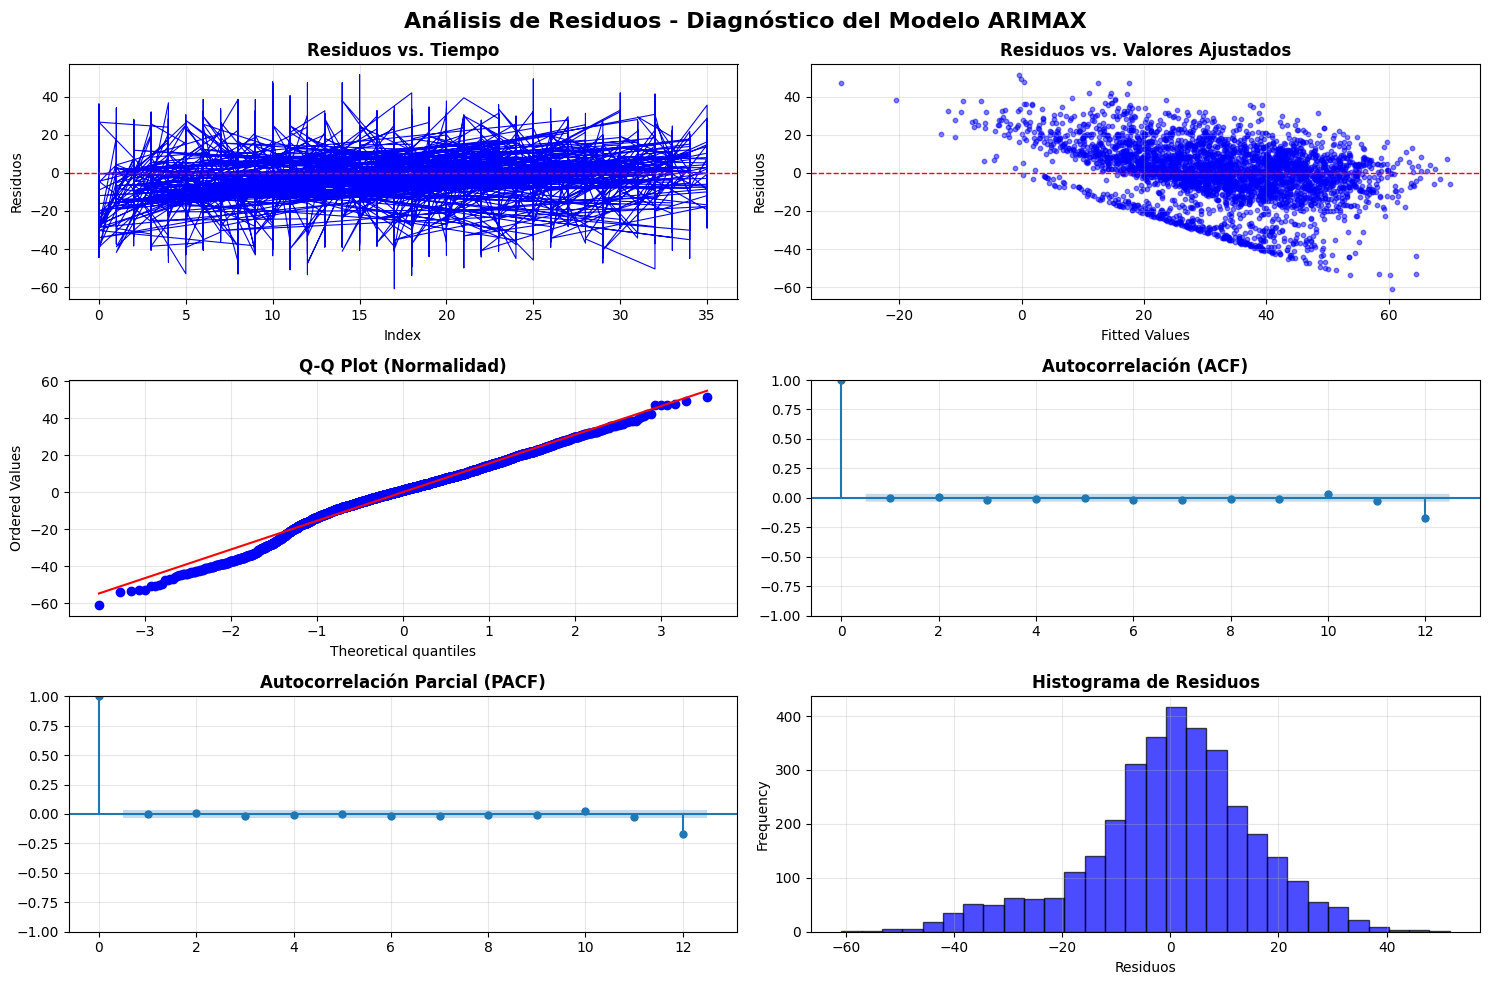

In [28]:
# Análisis de residuos para modelo Box-Cox

residuals_boxcox = auto_arima_model_boxcox.arima_res_.resid

print("-----------------Residues Analysis (White Noise) - Box-Cox -----------------")
sa.residual_white_noise_test(residuals_boxcox)
print("------------------------------------------------------------------") 

# ========== GRÁFICO DE DIAGNÓSTICO DE RESIDUOS ==========

# Obtener residuos y valores ajustados
residuals_boxcox = auto_arima_model_boxcox.arima_res_.resid
fitted_values_boxcox = auto_arima_model_boxcox.arima_res_.fittedvalues 

sa.analysis_residuals(residuals_boxcox, fitted_values_boxcox)